In [1]:
from mpmath import mp
import numpy as np

In [2]:
import glworia.amplification_factor
import glworia.lens_functions
from glworia.amplification_factor import *
from glworia.lens_functions import *
import glworia.load_interp
from glworia.load_interp import *
import glworia.plot

2023-09-14 17:54:26.469096: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
from importlib import reload

In [4]:
reload(glworia.amplification_factor)
reload(glworia.lens_functions)
from glworia.amplification_factor import *
from glworia.lens_functions import *
reload(glworia.load_interp)
from glworia.load_interp import *

In [5]:
from jax.config import config
config.update("jax_enable_x64", True)

In [39]:
mp.dps = 60

In [7]:
def SIS_term(n, w, y):
    term_1 = mp.gamma(1 + n/2)/mp.fac(n)
    term_2 = (2*w*mp.exp(3j*mp.pi/2))**(n/2)
    term_3 = mp.hyp1f1(1 + n/2, 1, -1j/2*w*y**2)
    return term_1*term_2*term_3

def SIS_sum(N, w, y):
    sum = 0
    for n in range(N):
        sum += SIS_term(n, w, y)
    return mp.exp(1j/2*w*y**2 + (0.5 + y)*1j*w)*sum

SIS_sum_vec = np.vectorize(SIS_sum, excluded=['N', 'y'])

In [8]:
from importlib import reload

In [9]:
reload(glworia.load_interp)
from glworia.load_interp import *

In [10]:
import matplotlib.pyplot as plt

# use latex
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [11]:
lp_name = 'x_c'

settings = {
    'lens_param_name': lp_name,
    'y_low': 0.1,
    'y_high': 5.0,
    lp_name + '_low': 0.,
    lp_name + '_high': 1.,
    'N_grid': 31,
    'N_grid_strong': 61,
    'N_crit': 61,
    'N': 200,
    'lens_model_name': 'CIS',

    'T0_max': 1000,

    'y_low_im': 0.1,
    'y_high_im': 5.0,
    lp_name + '_low_im': 0.,
    lp_name + '_high_im': 1.,
    'N_grid_im': 201,
    'N_crit_im': 201,
}

In [12]:
# def strong_lens_cond_override_gSIS(strongly_lensed, y_interp, kappa_interp):
#     if np.abs(kappa_interp - 1.) < 1e-15:
#         if y_interp < 1.:
#             strongly_lensed = True
#         else:
#             strongly_lensed = False
#     return strongly_lensed

In [13]:
interpolators = load_interpolators('./interpolation', **settings)

In [14]:
w_interp = np.linspace(0.01, 1e3, 10**5)

In [15]:
y_interp = 0.2
lp_interp = 0.

In [16]:
T_funcs, helper_funcs = amplification_computation_prep(Psi_CIS)

In [17]:
crit_curve_helper_funcs = make_crit_curve_helper_func(T_funcs)

In [18]:
def y_crit_override_CIS(y_crit, lens_params):
    if lens_params[0] < 1e-15:
        return 1.
    else:
        return y_crit

def origin_type_CIS(lens_params):
    if jnp.abs(lens_params[0]) > 1e-15:
        origin = 'regular'
    else:
        origin = 'cusp'
    return origin

In [19]:
bisection_1D_var_2D = make_bisection_1D_var_2D()
bisection_1D_cond_fun = make_bisection_1D_cond_fun(1e-13)
bisection_1D_step_fun = make_bisection_1D_step_fun(T_funcs["dT_1D"])

# @partial(jnp.vectorize, signature = '(3),(),()->(3)')
def x_im_nan_sub_CIS(x_im, y0, lens_params):
    lens_params = jnp.atleast_1d(lens_params)
    x_im = jax.lax.cond(jnp.isnan(x_im[1]) & (lens_params[0] > 0) & (y0 < 1.),
                        lambda x_im: x_im.at[1].set(
                            bisection_1D_var_2D(T_funcs["dT_1D"], 0., 
                                                -0.1, -1e-14, 
                                                bisection_1D_cond_fun, 
                                                bisection_1D_step_fun, 
                                                y0, lens_params[0])
                        ), 
                        lambda x_im: x_im, 
                        operand = x_im)
    return x_im

In [20]:
param_arr = jnp.linspace(0., 1., 100000)
add_indxs = jnp.where(param_arr < 1e-15)[0]
param_arr = param_arr[param_arr >= 1e-15]
crit_funcs = crtical_curve_interpolants(param_arr, T_funcs, crit_curve_helper_funcs, add_y = jnp.array([1.]), 
                                        add_x = jnp.array([0.]), add_param = jnp.array([0.]), add_indxs = add_indxs)

In [21]:
lens_params = jnp.array([lp_interp])

In [22]:
N = 200
T0_max = 1000.

F_computed_list = []
contour_obj_list = []

y_list = [0.2, 2.0]

for y_interp in y_list:
    y = jnp.array([y_interp, 0])
    F_computed, F_interp_raw, contour_obj, partitions = compute_F(w_interp, y, lens_params, T_funcs, helper_funcs, crit_funcs,
                N, T0_max, origin_type = origin_type_CIS, x_im_nan_sub = x_im_nan_sub_CIS,)
    F_computed_list.append(F_computed)
    contour_obj_list.append(contour_obj)

0.0045000000000000005 6.75
140 4.750077889447236 0.0045000000000000005 6.75
128 4.759787076083938 4.716180904522613 4.78397487437186
4.759787076083938


In [60]:
N_terms = 1000
F_analytic_list = []

In [61]:
mp.dps = 100

In [59]:
SIS_sum_vec(1000, 10**2, 2.0)

array(mpc(real='1.223310637458240537673581639835648532333325990277076319152759453219973537769538609621106100724300686904', imag='-0.001195848774969235905647979010460753389080998830367751990848208624084366692410915027472548405581221028408'),
      dtype=object)

In [62]:
ws = np.logspace(-1, 2, 1000)
for y_interp in y_list:
    Fs = SIS_sum_vec(N_terms, ws, y_interp)
    Fs = np.array(Fs.tolist(), dtype=np.complex128)
    F_analytic_list.append(Fs)
    
import pickle

for i, y_interp in enumerate(y_list):
    with open(f'./pickle/analytic_{N_terms}_y_{y_interp:.3f}_lp_{lp_interp:.3f}.pkl', 'wb') as f:
        pickle.dump(F_analytic_list[i], f)

In [63]:
import pickle 

F_analytic_list = []

for i, y_interp in enumerate(y_list):
    with open(f'./pickle/analytic_{N_terms}_y_{y_interp:.3f}_lp_{lp_interp:.3f}.pkl', 'rb') as f:
        F_analytic_list.append(pickle.load(f))

In [64]:
import matplotlib.pyplot as plt

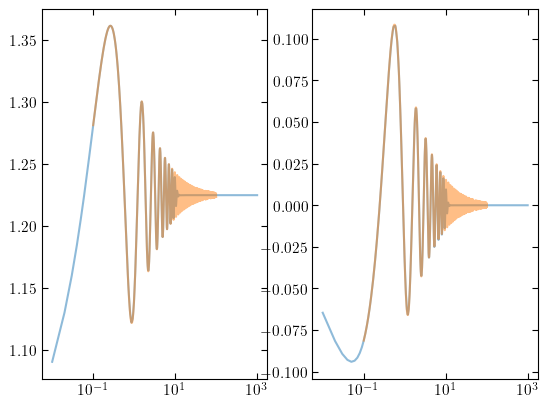

In [65]:
fig, axs = plt.subplots(1, 2)
axs[0].semilogx(w_interp, np.abs(F_computed), alpha = 0.5)
axs[0].set_xlim(*axs[0].get_xlim())
axs[0].set_ylim(*axs[0].get_ylim())
axs[0].semilogx(ws, np.abs(Fs), alpha = 0.5)
axs[1].semilogx(w_interp, np.angle(F_computed), alpha = 0.5)
axs[1].set_xlim(*axs[1].get_xlim())
axs[1].set_ylim(*axs[1].get_ylim())
axs[1].semilogx(ws, np.angle(Fs), alpha = 0.5)
# plt.axhline(np.sqrt(mu_min))

In [66]:
from scipy.interpolate import interp1d

F_interp_2_list = []
for F_computed in F_computed_list:
    F_interp_func = interp1d(w_interp, F_computed, kind = 'cubic', bounds_error = False, fill_value = 0.)
    F_interp_2 = F_interp_func(ws)
    F_interp_2_list.append(F_interp_2)


In [67]:
mu_min_list = [contour_obj.mu(contour_obj.x_im_min, lens_params) for contour_obj in contour_obj_list]

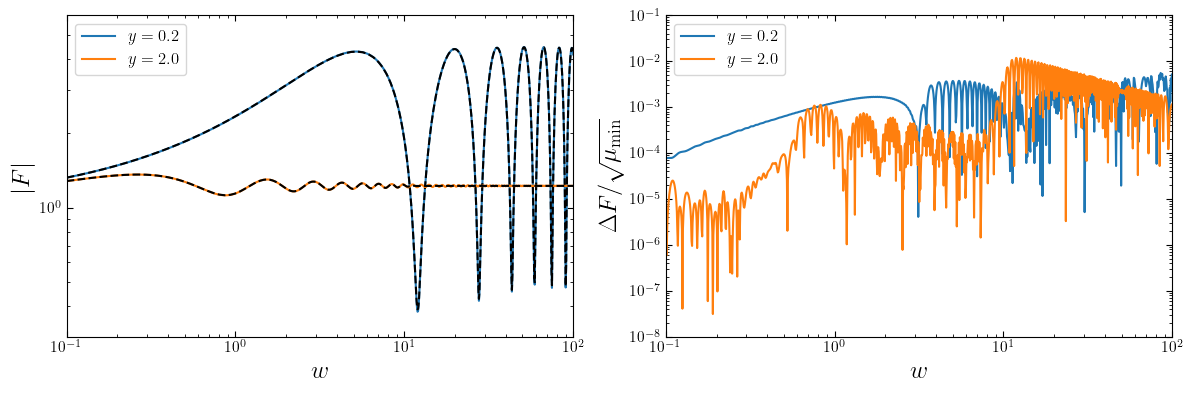

In [81]:
fig, axs = plt.subplots(1, 2, figsize = (12, 4))

labels = [r'$y = 0.2$', r'$y = 2.0$']

for i in range(len(F_computed_list)):
    axs[0].loglog(ws, np.abs(F_analytic_list[i]), c = f'C{i}', label = labels[i])
    axs[0].loglog(ws, np.abs(F_interp_2_list[i]), c = 'k', ls = '--')

axs[0].set_ylim(0.3, 6)
axs[0].set_xlim(0.1, 100)

axs[0].set_xlabel(r'$w$')
axs[0].set_ylabel(r'$|F|$')

for i in range(len(F_computed_list)):
    axs[1].loglog(ws, 
                  np.abs(np.abs(F_interp_2_list[i]) - np.abs(F_analytic_list[i]))/np.abs(np.sqrt(mu_min_list[i])),
                  c = f'C{i}', label = labels[i])
axs[1].set_ylim(1e-8, 1e-1)
axs[1].set_xlim(0.1, 100)

axs[1].set_xlabel(r'$w$')
axs[1].set_ylabel(r'$\Delta F/ \sqrt{\mu_{\rm min}}$')

axs[0].legend()
axs[1].legend()

fig.tight_layout()

plt.savefig('./plots/analytic_comparison.pdf', bbox_inches = 'tight')

In [ ]:
interpolators = load_interpolators('./interpolation', **settings)
w_interp = np.linspace(0.001, 1e4, 10**6)

Text(0, 0.5, '$\\Delta F/ \\sqrt{\\mu_{\\rm min}}$')

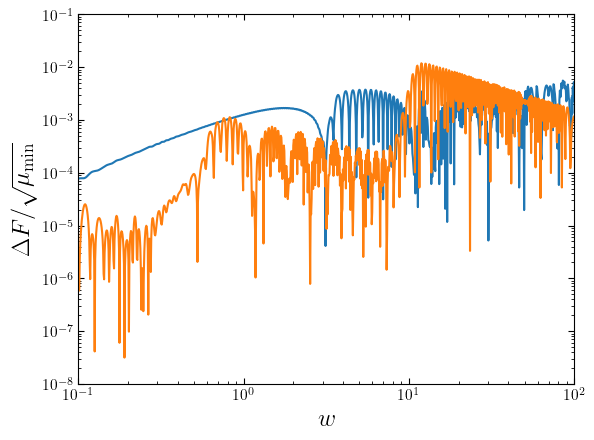

In [71]:
fig, ax = plt.subplots()

for i in range(len(F_computed_list)):
    ax.loglog(ws, np.abs(np.abs(F_interp_2_list[i]) - np.abs(F_analytic_list[i]))/np.abs(np.sqrt(mu_min_list[i])))
ax.set_ylim(1e-8, 1e-1)
ax.set_xlim(0.1, 100)

ax.set_xlabel(r'$w$')
ax.set_ylabel(r'$\Delta F/ \sqrt{\mu_{\rm min}}$')

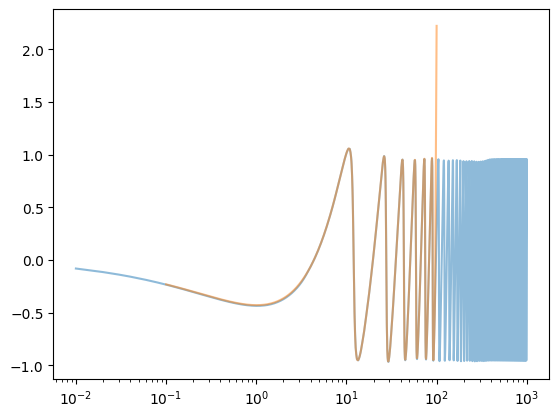

In [263]:
plt.semilogx(w_interp, np.unwrap(np.angle(F)), alpha = 0.5)
# plt.xlim(*plt.xlim())
# plt.ylim(*plt.ylim())
plt.semilogx(ws, np.unwrap(np.angle(Fs)), alpha = 0.5)
# plt.semilogx(ws, -ws/2)
# plt.semilogx(ws, -ws)